In [1]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('/Users/nguyenhalinh/Desktop/Research/RidingMowerData.xlsx')
df['mowerid'] = df.index
df.head()

,Income,LotSize,Ownership,mowerid
0,60.0,18.4,1,0
1,85.5,16.8,1,1
2,64.8,21.6,1,2
3,61.5,20.8,1,3
4,87.0,23.6,1,4


## DEA Model

In [3]:
class DEA_Score:
    """ A class to calculate DEA score and get the weights for each application"""
    
    def __init__(self, df, number_applications):
        """
        df: dataframe of all applications used to calculate DEA score
        number_applications: number of applications in the dataframe needed to calculate DEA score
        correlation: Point-Biserial correlation dictionary where the key is the variable name and value is correlation
        """
        self.number_applications = number_applications
        self.df = df


    def DEA(self, app_index):
        """ A function to calculate DEA score using optimization
            - app_index: the index of application to be optimized
            - Return DEA score and a list of weights for that application
        """
        env = gp.Env(empty=True)
        env.setParam('OutputFlag',0)
        env.start()
        model = gp.Model()

        weights = []

        E = model.addVar(ub=1)
        w = model.addVars(self.number_applications)
        
        #Income and LotSize are inputs
        model.addConstr(gp.quicksum(self.df['Income'][j]*w[j] for j in range(self.number_applications)) <= self.df['Income'][app_index]*E )
        model.addConstr(gp.quicksum(self.df['LotSize'][j]*w[j] for j in range(self.number_applications))  <= self.df['LotSize'][app_index]*E)

    
        #sum of weights equal 1
        model.addConstr(gp.quicksum(w[j] for j in range(self.number_applications))  == 1)

        model.setObjective(E)
        model.optimize()

        weights = [w[i].x for i in range(self.number_applications)]
        

        return model.ObjVal,weights

    
    def new_data(self):
        """ A function to get all the DEA scores and weights of the dataframe"""
        weights = {}
        dea_list = []

        for i in range (self.number_applications): #number of applications
            dea, weight = self.DEA(i) 

            dea_list.append(dea)
            print("Processing DMU %i, Efficiency score %.3f" % (i, dea))
            for j in range (self.number_applications):
                if 'weights' + str(j) not in weights:
                    weights['weights' + str(j)] = [weight[j]]
                else:
                    weights['weights' + str(j)].append(weight[j])  
        return dea_list, weights

## Run DEA for Ownership = 1 only

In [4]:
# DEA mower (only run DEA for mower (ownership=1))
df_mower = df[df['Ownership '] == 1]
df_mower_copy = df_mower.copy()
DEA_mower = DEA_Score(df_mower_copy,df_mower_copy.shape[0])

DEA_score_mower = DEA_mower.new_data()[0]
weights_mower = DEA_mower.new_data()[1]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3 rows, 13 columns and 38 nonzeros
Model fingerprint: 0x36794e8e
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 3 rows, 13 columns, 38 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.210000e+01   0.000000e+00      0s
       2    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.000000000e+00
Processing DMU 0, Efficiency score 1.000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: In

In [5]:
df_mower_copy['DEA'] = DEA_score_mower
for j in range(df_mower_copy.shape[0]):
    df_mower_copy['weight' + str(j)] = weights_mower['weights' + str(j)]
df_mower_copy[df_mower_copy['DEA']==1]

,Income,LotSize,Ownership,mowerid,DEA,weight0,weight1,weight2,weight3,weight4,weight5,weight6,weight7,weight8,weight9,weight10,weight11
0,60.0,18.4,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,85.5,16.8,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,51.0,22.0,1,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Plot Results

In [17]:
def plot_scatter2D(allmowers, mower, nonmower, c1, c2):
    """A function to draw 2D curve to visualize the efficient frontier """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    mower1 = mower[mower['DEA'] == 1]
    mower2 = mower[mower['DEA'] != 1]
    
    #Find removed record
    removed_df = pd.merge(allmowers, mower, on='mowerid', how='left', indicator=True).query('_merge == "left_only"').reset_index(drop=True)
    removed_id = []
    ax1 = mower2.plot.scatter(x=c1, y=c2, c='b', ax=ax, label='mower')
    ax2 = mower1.plot.scatter(x= c1, y= c2, ax=ax, c='r', label='DEA=1')
    ax3 = nonmower.plot.scatter(x= c1, y= c2, ax=ax, c='LightGreen',  label='nonmower')
    ax4 = removed_df.plot.scatter(x= c1+'_x', y= c2+'_x', ax=ax, c='Orange',  label='removed')
    
    for i in range(len(mower)):
        if i in mower1.index:
            ax2.annotate(mower['mowerid'][i], (mower[c1][i], mower[c2][i]), color='r')
        else:
            ax1.annotate(mower['mowerid'][i], (mower[c1][i], mower[c2][i]), color='DarkBlue')
    
    for i in range(len(nonmower)):
        ax3.annotate(nonmower['mowerid'][i], (nonmower[c1][i], nonmower[c2][i]), color='LightGreen')
    
    for i in range(len(removed_df)):   
        removed_id.append(removed_df['mowerid'][i])
        ax4.annotate(removed_df['mowerid'][i], (removed_df[c1+"_x"][i], removed_df[c2+"_x"][i]), color='Orange')
    
    return ax

<AxesSubplot:xlabel='Income_x', ylabel='LotSize_x'>

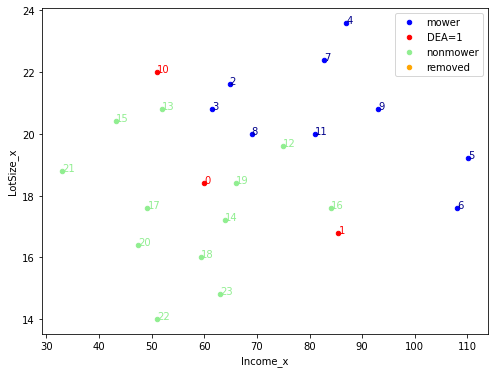

In [18]:
df_nonmower = df[df['Ownership '] == 0].reset_index(drop=True) #find records that ownership = 0
plot_scatter2D(df_mower, df_mower_copy , df_nonmower, 'Income','LotSize')

## Find all possible combinations of records that have DEA=1

In [19]:
def find_subsets(input_set):
    """
    Function to find all subsets of a given set using dynamic programming.
    
    Parameters:
    - input_set: The input list for which subsets are to be found.
    
    Returns:
    A list of all subsets.
    """
    n = len(input_set)
    all_subsets = [[]] # Start with an empty subset
    
    for element in input_set:
        all_subsets.extend([subset + [element] for subset in all_subsets])

    return list(all_subsets)

In [20]:
given_set = set(df_mower_copy[df_mower_copy['DEA']==1]['mowerid'].tolist())
result_subsets = find_subsets(given_set) #Remove the first empty list

print("Given Set:", given_set)
print("All Subsets:", result_subsets)

Given Set: {0, 1, 10}
All Subsets: [[], [0], [1], [0, 1], [10], [0, 10], [1, 10], [0, 1, 10]]


## Confusion Matrix

In [21]:
from scipy.interpolate import CubicSpline

def count_points_under_curve(set_A, set_B):
    # Separate the x and y coordinates of set A and sort based on x
    x_points_A, y_points_A = zip(*sorted(set_A))

    # Create a cubic spline interpolation for set A
    spline_A = CubicSpline(x_points_A, y_points_A)

    # Count the number of points from set B under the curve formed by set A
    num_points_under_curve = sum(y < spline_A(x) for x, y in set_B)

    # Visualize the original points, the estimated curve, and the points to check
    plt.scatter(*zip(*set_A), color='red')
    plt.scatter(*zip(*set_B), color='LightGreen')
    plt.plot(np.linspace(min(x_points_A), max(x_points_A), 100), spline_A(np.linspace(min(x_points_A), max(x_points_A), 100)), label='Estimated Curve', color='green')
    
    # Add labels and title
#     plt.title('Curve and Points Visualization')
    
    # Display the legend
    plt.legend()
    
    # Show the plot
#     plt.show()

    return num_points_under_curve


In [22]:
def perfMetrics(TP, TN, FN, FP):
    """
    Create a 2D array representing a confusion matrix.

    Parameters:
    - TP: Number of true positives
    - TN: Number of true negatives
    - FN: Number of false negatives
    - FP: Number of false positives

    Returns:
    - A 2D array representing the confusion matrix.
    - A dictionary containing precision, accuracy, and F1 score.
    """
    confusion_matrix = np.array([[TP, FP],
                                 [FN, TN]])
    
    
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

    metrics = {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'Precision': round(precision,3),
        'Recall': round(recall,3),
        'Accuracy': round(accuracy,3),
        'F1': round(f1_score,3)
    }
    
    return confusion_matrix, metrics

SUBSET 0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3 rows, 13 columns and 38 nonzeros
Model fingerprint: 0x36794e8e
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 3 rows, 13 columns, 38 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.210000e+01   0.000000e+00      0s
       2    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.000000000e+00
Processing DMU 0, Efficiency score 1.000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
Thread count: 4 physical cores, 8 logical

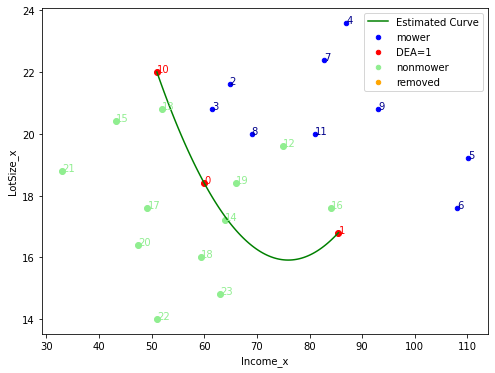

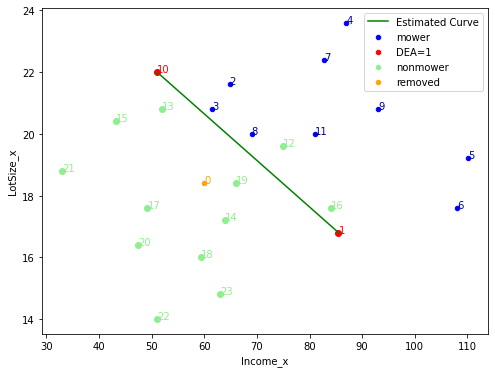

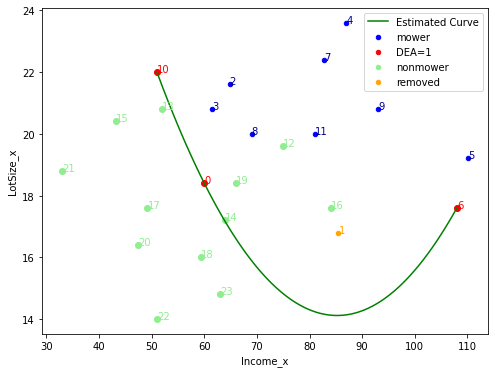

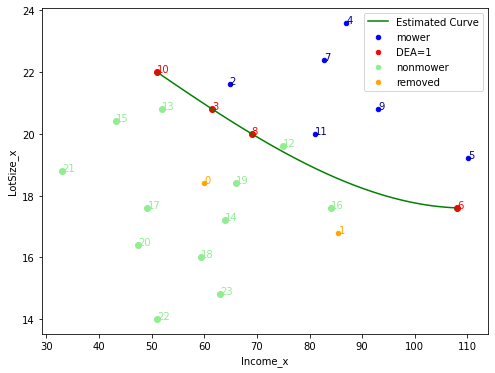

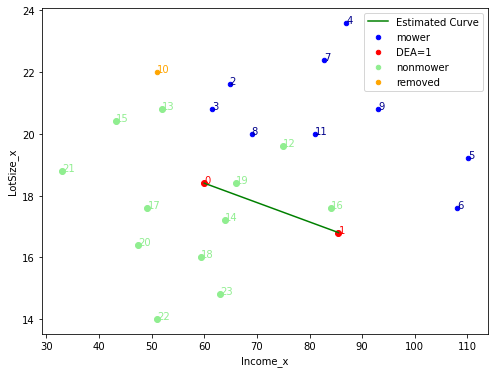

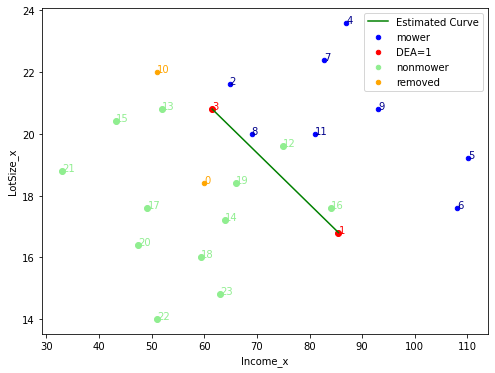

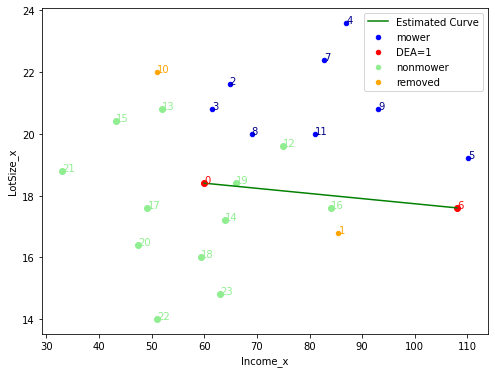

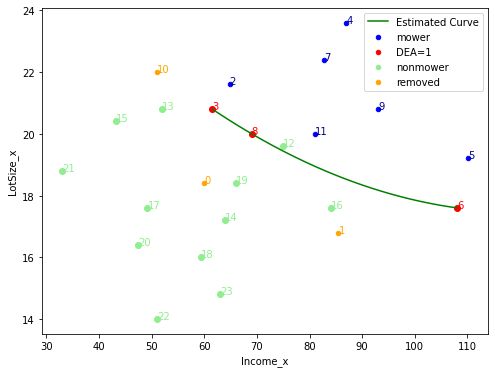

In [23]:
# DEA mower (only run DEA for mower (ownership=1))
df_mower = df[df['Ownership '] == 1]
# dea_org = df_mower_copy[df_mower_copy['DEA']==1]
points_set_B = list(df_nonmower[['Income','LotSize']].apply(tuple, axis=1)) #points where DEA = 1

#Result dataframe
result_df = pd.DataFrame(columns=['Removed_Index','TP','TN','FP','FN','Precision','Recall','Accuracy','F1'])

for i in range(len(result_subsets)):
    print("SUBSET",i)
    #Run DEA after removing some subsets of records where DEA = 1
    df_mower_subset = df_mower.copy().drop(index=result_subsets[i]).reset_index(drop=True) #drop index if DEA=1
    DEA_mower = DEA_Score(df_mower_subset,df_mower_subset.shape[0])

    DEA_score_mower = DEA_mower.new_data()[0] #Get DEA score
    weights_mower = DEA_mower.new_data()[1] #Get weights for each record

    df_mower_subset['DEA'] = DEA_score_mower #Assign a new column for DEA score

    #Assign columns for each weight
    for j in range(df_mower_subset.shape[0]):
        df_mower_subset['weight' + str(j)] = weights_mower['weights' + str(j)]

#     df_mower_subset.to_csv('dearemove'+str(result_subsets[i])+'.csv')

    #Plot results
    plot_scatter2D(df_mower, df_mower_subset ,df_nonmower,'Income','LotSize')

    df_mower_dea1 = df_mower_subset[df_mower_subset['DEA'] == 1]
    points_set_A = list(df_mower_dea1[['Income','LotSize']].apply(tuple, axis=1)) #points where DEA = 1

    true_pos = len(df_mower_subset)
    false_neg = len(result_subsets[i])
    true_neg = count_points_under_curve(points_set_A,points_set_B)
    false_pos = len(df_nonmower) - true_neg
    result = perfMetrics(true_pos, true_neg, false_neg, false_pos)[1]
    result['Removed_Index'] = result_subsets[i]
    result_df = result_df.append(result, ignore_index=True)
    plt.savefig('dearemove' + str(result_subsets[i]))

In [24]:
result_df

,Removed_Index,TP,TN,FP,FN,Precision,Recall,Accuracy,F1
0,[],12,9,3,0,0.800,1.000,0.875,0.889
1,[0],11,10,2,1,0.846,0.917,0.875,0.880
2,[1],11,8,4,1,0.733,0.917,0.792,0.815
3,"[0, 1]",10,11,1,2,0.909,0.833,0.875,0.870
4,[10],11,7,5,1,0.688,0.917,0.750,0.786
5,"[0, 10]",10,10,2,2,0.833,0.833,0.833,0.833
6,"[1, 10]",10,8,4,2,0.714,0.833,0.750,0.769
7,"[0, 1, 10]",9,11,1,3,0.900,0.750,0.833,0.818


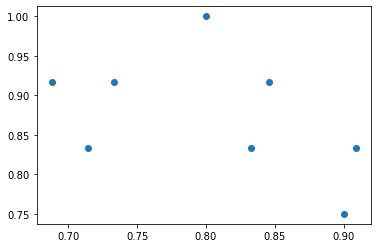

In [25]:
plt.scatter(x=result_df['Precision'],y=result_df['Recall'])
# plt.ylim(0,1)
# plt.xlim(0,1)
plt.show()